Survivor WSSYW Ranking
==
This project is a visualization of the Annual Survivor: What Season Should You Watch (WSSYW) Thread, which ranks Survivor seasons by their general watchability. The goal of this visualization is to elucidate trends in season favorability over time. Visualizations inspired by [Dominik Koch](https://dominikkoch.github.io/Bump-Chart/).

All data sourced from [r/survivor](https://www.reddit.com/r/survivor/)

### Import Libraries
Import relevant libraries

In [21]:
import praw
import re
import pandas as pd
from praw.models import MoreComments
import numpy as np
from datetime import datetime, timezone
import json

# Read in dictionaries that map season number to season name and era
fp = open('./seasons.json')
seasons = json.load(fp)

fp = open('./era.json')
eras = json.load(fp)

season_df = pd.DataFrame.from_dict(seasons, orient="index").reset_index()
season_df.columns = ['season_nbr', 'season']

### Connect to API
Use the Python Reddit API Wrapper to extract the top level comments from the 8 Survivor WSSYW historical posts

In [ ]:
# Track date of data pull
pull_date = datetime.now().strftime("%b %d %Y %H:%M:%S")

# Create connection to Reddit via PRAW
fp = open('./settings.json')
settings = json.load(fp).get('praw')
reddit = praw.Reddit(client_id = settings.get('client_id'),
                    client_secret = settings.get('client_secret'),
                    user_agent = settings.get('user_agent'),
                    username = settings.get('username'),
                    password = settings.get('password'))
subreddit = reddit.subreddit('survivor')
wssyw_ids = ['10tpq9', # e.g. S06: The Amazon, hyperlinked
             '26viy4', # e.g. Season 28: Cagayan
             '37c7zu', # e.g. S15: China
             '3xp433', 
             '4kzd4g', 
             '5jwzib', 
             '6ga0ty', # [Season 7: Pearl Islands](link to countdown)
             '8p0ye9', 
             'btu8iu'  # Note: Still posting countdown
            ]
wssyw_submissions = []
for r_id in wssyw_ids:
    submission = reddit.submission(id=r_id)
    submission.comments.replace_more(limit=40, threshold=0)
    wssyw_submissions.append(submission)

### Create dataframe of poll results
For each post, iterate through top level comments by the original poster, find the posts about each american Survivor season, and map the comment's vote score to results dataframe

In [3]:
df_dict = []
df_dict.append(seasons)
df_dict.append(eras)

score_df = df_dict.copy()
post_dates = []
for post in wssyw_submissions:
    poster = post.author
    score_dict = {}
    # Keep list of when each version was posted
    post_dates.append(datetime.fromtimestamp(post.created_utc).strftime('%b %Y'))
    
    # For each top level comment, identify season and map karma score
    for top_level_comment in post.comments:
        # Filter out top comments not by original poster
        if top_level_comment.author != poster:
            continue
        season = None
        match1 = re.search("(\d+:( (\w|-)+|\.+){1,})",top_level_comment.body)
        match2 = re.search("(:(\d+)( (\w|-)+|\.+){1,})",top_level_comment.body) # Data error of S:00 Example Name
        if match1:
            season = str(int(match1.group().split(': ')[0]))
        elif match2:
            season = str(int(match2.group().split(':')[1].split(' ')[0]))
        if match1 or match2:
            score = top_level_comment.score
            score_dict[season] = score
    score_df.append(score_dict)
    
df = pd.DataFrame(score_df).transpose()
df.columns = ['season','era','1.0','2.0','3.0','4.0','5.0','6.0','7.0','8.0','9.0']
df = df.fillna(np.nan)

# Save csv for reference
df.to_csv('./data/season_score_raw.csv',index = None, header=True)

### Create dataframes with ranking based on WSSYW version

In [38]:
df_ranked = pd.read_csv("./data/season_score_raw.csv")
df = df_ranked
df_pivot = pd.DataFrame(columns=['season','era','rank','version','new'])

# Determine which seasons ever entered the top or bottom n ranking
show_top = 5

# Define mutable variables
prev = None
top_cols = []
bottom_cols = []
for col in df.columns:
    df_new = pd.DataFrame(columns=['season','era','rank','version','new'])
    if df[col].dtypes == 'float64' or df[col].dtypes == 'int64':
        df_ranked['%s rank'%col]=df[col].rank(ascending=False, na_option='bottom', method='first')
        df_ranked['%s rank bottom'%col]=df[col].rank(ascending=True, na_option='bottom', method='first')
        
        df_ranked['top_n_%s'%col]=[True if x <= show_top else False for x in df_ranked['%s rank'%col]]
        top_cols.append('top_n_%s'%col)
        
        df_ranked['bottom_n_%s'%col]=[True if x <= show_top else False for x in df_ranked['%s rank bottom'%col]]
        bottom_cols.append('bottom_n_%s'%col)
        df_new['season'] = df['season']
        df_new['era'] = df['era']
        df_new['rank'] = df[col].dropna().rank(ascending=False, na_option='bottom', method='first')
        df_new['rank_bottom'] = df[col].dropna().rank(ascending=True, na_option='bottom', method='first')
        df_new['version'] = col
        if prev != None:
            df_new['new'] = df_ranked[prev].isnull()
        else:
            df_new['new'] = False
        df_pivot = pd.concat([df_pivot, df_new], sort=False)
        prev = col

df_ranked['top_n'] = df_ranked[top_cols].any(axis='columns')
df_ranked['bottom_n'] = df_ranked[bottom_cols].any(axis='columns')
df_ranked = df_ranked.drop(columns=top_cols)
df_ranked = df_ranked.drop(columns=bottom_cols)
df_pivot = df_pivot.reset_index()
df_pivot = df_pivot.join(df_ranked[['season','top_n']].set_index('season'), on='season')
df_pivot = df_pivot.join(df_ranked[['season','bottom_n']].set_index('season'), on='season')
df_pivot = df_pivot.merge(season_df, on='season', how='left')
df_pivot.to_csv('./data/season_rankings.csv',index = None, header=True)

In [24]:
df_pivot

,index,season,era,rank,version,new,rank_bottom,top_n,bottom_n,season_nbr
0,0,Borneo,Classic Era,9.0,1.0,NaN,16.0,False,False,1
1,1,Palau,Transitional Era,10.0,1.0,NaN,14.0,False,False,10
2,2,Guatemala,Transitional Era,14.0,1.0,NaN,11.0,False,False,11
3,3,Panama,Transitional Era,16.0,1.0,NaN,9.0,False,False,12
4,4,Cook Islands,Transitional Era,5.0,1.0,NaN,20.0,True,False,13
...,...,...,...,...,...,...,...,...,...,...
337,33,Thailand,Classic Era,33.0,9.0,False,6.0,False,True,5
338,34,The Amazon,Classic Era,16.0,9.0,False,23.0,False,False,6
339,35,Pearl\nIslands,Classic Era,3.0,9.0,False,36.0,True,False,7
340,36,All-Stars,Classic Era,32.0,9.0,False,8.0,False,True,8


### Set plot theme using plotnine
Define the background, format the grid, remove the legend, and format the title and axes

In [33]:
from plotnine import *

# Define colors
color_background = "white"
color_text = "#22211d"

# Define the theme to be used on all graphs
my_theme = (

    # Begin construction of chart
    theme_bw(base_size=15) +

    # Format background colors
    theme(panel_background = element_rect(fill=color_background, color=color_background)) +
    theme(plot_background  = element_rect(fill=color_background, color=color_background)) +
    theme(panel_border     = element_rect(color=color_background)) +
    theme(strip_background = element_rect(fill=color_background, color=color_background)) +

    # Format the grid
    theme(panel_grid_major_y = element_blank()) +
    theme(panel_grid_minor_y = element_blank()) +
    theme(axis_ticks         = element_blank()) +

    # Format the legend
    theme(legend_position = "none") +

    # Format title and axis labels
    theme(plot_title       = element_text(color=color_text, size=20, weight = "bold")) +
    theme(axis_title_x     = element_text(size=10, color="black", weight = "bold")) +
    theme(axis_title_y     = element_text(size=10, color="black", weight = "bold")) +
    theme(axis_text_x      = element_text(size=12, vjust=0.5, hjust=0.5, color = color_text)) +
    theme(axis_text_y      = element_text(size=12, color = color_text)) +
    theme(strip_text       = element_text(face = "bold")) +

    # Plot margins
    theme(figure_size = (12,6))
    )


### Create plots
Create plots to visualize the data. Group data sets by "era" using color.
1. Top 15 seasons and how they've changed over time
2. Bottom 15 seasons and how they've changed over time
3. All seasons

In [34]:
from plotnine import *

# Add formatting color columns for highlighting only the top n/bottom n seasons
df_pivot['era_col_top'] = [x[1]['era'] if x[1]['top_n']==True else 'None' for x in df_pivot.iterrows()]
df_pivot['era_col_bottom'] = [x[1]['era'] if x[1]['bottom_n']==True else 'None' for x in df_pivot.iterrows()]

# Remove any rows where the data value (rank) is NaN
df_pivot = df_pivot.dropna(subset=['rank'])

# Set the color mapping schema by the era
cmap_era = {"Classic Era":"#F70020","Golden Age":"#1A7D00","Meta Era":"#0C96F2","Revival Era":"#FB9701","Transitional Era":"#636666","Dark Ages":"#87603E","None":"#BFBEBB"}

In [35]:
# Create the base graph figure. Format the points, lines, axes, set limits, and assign color mapping
def base_fig(df, rank_col, color_col, cmap, show_top=38):
    return (
    ggplot(data=df, mapping=aes(x='version', y=rank_col, group='season')) +
    
    # Format data points
    geom_line(aes(color = color_col, alpha = 1), size = 2) +
    geom_point(aes(color = color_col, alpha = 1), size = 4) +
    geom_point(color = "#FFFFFF", size = 1) +
    geom_point(data=df_pivot.loc[df_pivot['new']==True], mapping=aes(color=color_col, alpha=1), shape='*', size=9) +
    geom_point(data=df_pivot.loc[df_pivot['new']==True], color='#FFFFFF', shape='*', size=3) +
    
    # Scale reverse for showing top rankings
    scale_y_reverse(limits=[1,38], breaks=range(show_top,0,-1)) +
    
    # Ranking at WSSYW 1.0
    geom_text(data = df_pivot.loc[df_pivot['version']=='1.0'],
        mapping=aes(label = 'season', x = 0.8, y = rank_col, color=color_col), ha = 'right', size=9) +
    # Ranking at WSSYW 9.0
    geom_text(data = df_pivot.loc[df_pivot['version']=='9.0'],
        mapping=aes(label = 'season', x = 9.2, y = rank_col, color=color_col), ha = 'left', size=9) +
    
    # Set limits on graph
    coord_cartesian(xlim=(0.5,9.5),
                    ylim=(show_top,1))  +
    
    # Map colors by color_col value
    scale_color_manual(cmap)
)


In [ ]:
# Create graph of top 15 seasons by ranking over time
fig = base_fig(df=df_pivot, rank_col='rank', color_col='era_col_top', show_top=15, cmap=cmap_era)

top_fig = fig + labs(x = "WSSYW Version",
        y = "Season Ranking",
        title = "Top Seasons") + my_theme + theme(axis_title_x=element_blank())
ggsave(plot=top_fig, filename='./images/top_seasons.png')

In [8]:
# Create graph of worst 15 seasons by ranking over time
fig = base_fig(df=df_pivot, rank_col='rank_bottom', color_col='era_col_bottom',show_top=15, cmap=cmap_era)

bottom_fig = fig + labs(x = "WSSYW Version",
        y = "Worst Season Ranking",
        title = "Worst Seasons") + my_theme
ggsave(plot=bottom_fig, filename='./images/bottom_seasons.png')

/anaconda3/lib/python3.7/site-packages/plotnine/ggplot.py:706: UserWarning: Saving 12 x 6 in image.
  from_inches(height, units), units))
/anaconda3/lib/python3.7/site-packages/plotnine/ggplot.py:707: UserWarning: Filename: bottom_seasons.png
  warn('Filename: {}'.format(filename))
/anaconda3/lib/python3.7/site-packages/plotnine/layer.py:517: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  return not cbook.iterable(value) and (cbook.is_numlike(value) or
/anaconda3/lib/python3.7/site-packages/plotnine/layer.py:517: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  return not cbook.iterable(value) and (cbook.is_numlike(value) or
/anaconda3/lib/python3.7/site-packages/plotnine/layer.py:517: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  return not cbook.iterable(value) and (cbook.is_numlike(value) or
/anaconda3/lib/python3.7/site-packages/plotnine/layer.py:517: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  return not cbook.i

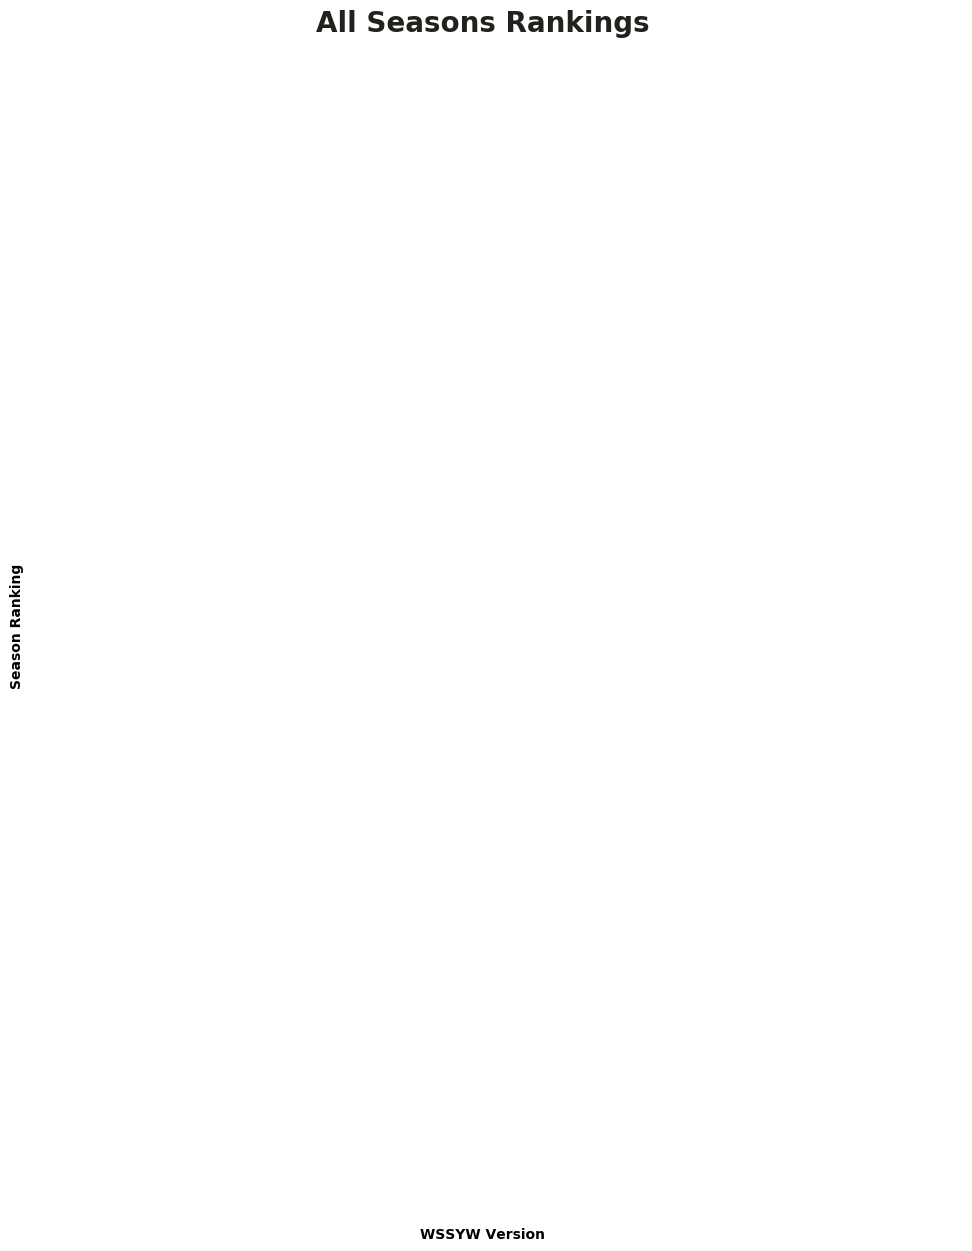

<ggplot: (296993891)>


In [31]:
# Create graph to visualize all rankings over time
fig = base_fig(df=df_pivot, rank_col='rank', color_col='era', cmap=cmap_era)

all_fig = fig + labs(x = "WSSYW Version",
        y = "Season Ranking",
        title = "All Seasons Rankings") + my_theme + theme(figure_size = (12,15.2)) + coord_cartesian(xlim=(0.5,9.5),ylim=(37,2))
# ggsave(plot=all_fig, filename='./images/all_seasons.png')
print(all_fig)

In [25]:
df_pivot

,index,season,era,rank,version,new,rank_bottom,top_n,bottom_n,season_nbr
0,0,Borneo,Classic Era,9.0,1.0,NaN,16.0,False,False,1
1,1,Palau,Transitional Era,10.0,1.0,NaN,14.0,False,False,10
2,2,Guatemala,Transitional Era,14.0,1.0,NaN,11.0,False,False,11
3,3,Panama,Transitional Era,16.0,1.0,NaN,9.0,False,False,12
4,4,Cook Islands,Transitional Era,5.0,1.0,NaN,20.0,True,False,13
...,...,...,...,...,...,...,...,...,...,...
337,33,Thailand,Classic Era,33.0,9.0,False,6.0,False,True,5
338,34,The Amazon,Classic Era,16.0,9.0,False,23.0,False,False,6
339,35,Pearl\nIslands,Classic Era,3.0,9.0,False,36.0,True,False,7
340,36,All-Stars,Classic Era,32.0,9.0,False,8.0,False,True,8


### Take plots and combine them into one image

In [13]:
from PIL import Image, ImageDraw, ImageFont

def getHeight(box):
    return (box[3] - box[1])
def getWidth(box):
    return (box[2]-box[0])
def center(x,y,msg,draw,f=None):
    w, h = draw.textsize(msg,font=f)
    return (x-w/2,y-h/2)
    
images = [Image.open(x) for x in ['all_seasons.png', 'top_seasons.png', 'bottom_seasons.png']]
w, h = zip(*(i.size for i in images))
W = w[0] + w[2]
H = h[0] + 120+150

all_box = (0,120,w[0],h[0]+120)
worst_box = (W-w[2],getHeight(all_box)+120-h[2],W,getHeight(all_box)+120)
best_box = (W-w[1],worst_box[1]-h[1],W,worst_box[1])


final_img = Image.new('RGB', (W,H), 'white')
final_img.paste(images[0], all_box)
final_img.paste(images[1], best_box)
final_img.paste(images[2], worst_box)

draw = ImageDraw.Draw(final_img)
fnt = ImageFont.truetype('/Library/Fonts/Arial Bold.ttf', 45)

title = "What Season of Survivor Should You Watch?"
pos = center(W/2, 40, title, draw, fnt)
draw.text(pos, title, fill='black', font=fnt)

subtitle = "Visualizing the \"watchability\" ranking of each season of Survivor"
fnt = ImageFont.truetype('/Library/Fonts/Arial.ttf', 30)
pos = center(W/2, 80, subtitle, draw, fnt)
draw.text(pos, subtitle, fill='black', font=fnt, spacing=10)

bottom_text = (
"All data was taken from the results of each installment of \"What Season Should You Watch (WSSYW)\" \
on r/survivor, which ranks every season of Survivor by watchability as an unspoiled reference for \
people who have \nnot seen the season.\n\n\
*The watchability ranking was determined by the number of upvotes/downvotes on a given season per WSSYW post as of %s\n"%pull_date +
"**The %d WSSYW installments were posted in: "%len(post_dates)+', '.join(['%s']*len(post_dates))%tuple(post_dates)
)
fnt = ImageFont.truetype('/Library/Fonts/Arial.ttf', 20)
pos = center(W/2, H-75, bottom_text, draw, fnt)
draw.multiline_text(pos, bottom_text, fill='black', font=fnt, spacing=5)

# Create legend
pad = 20
xpad = 75
box_h = (h[0]-(h[1]+h[2]))/2
box_w = (w[1]-xpad)/3

def draw_rect(x,y,w,h,era,desc):
    x1 = x+pad/2
    x2 = x1+w-pad
    y1 = y+pad/2
    y2 = y1+h-pad 
    rect = [x1,y1,x2,y2]
    draw.rectangle(rect,fill=cmap_era.get(era))
    draw.text((rect[0]+box_h,y+h/2-fontsize),era,fill='black',font=fnt)
    draw.text((rect[0]+box_h,y+h/2),desc,fill='black',font=sub_fnt)

fontsize = 26
fnt = ImageFont.truetype('/Library/Fonts/Arial.ttf', fontsize)
sub_fnt = ImageFont.truetype('/Library/Fonts/Arial Italic.ttf', fontsize)

legend = [
    [
        ['Classic Era','Seasons 1-8'], 
        ['Transitional Era', 'Seasons 9-14'], 
        ['Golden Age','Seasons 15-20']],
    [
        ['Dark Ages','Seasons 21-24'], 
        ['Revival Era','Seasons 25-30'],
        ['Meta Era', 'Seasons 31-Present']]
]

[[draw_rect(W/2+xpad/2+i*box_w, 120+j*box_h, box_h, box_h, legend[j][i][0], legend[j][i][1]) for i in range(3)] for j in range(2)]

final_img.save('./images/survivor_wssyw.png')